In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [126]:
import pandas as pd

# Load the CSV files
fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
real = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")

# Label the data
fake['label'] = 0  # Fake news
real['label'] = 1  # Real news

# Combine into one DataFrame
df = pd.concat([fake, real])
df = df[['title', 'label']]  # Only use headline and label
df.head()


,title,label
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [127]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)     # Remove special characters
    text = re.sub(r'\s+', ' ', text)    # Remove extra spaces
    return text

df['cleaned'] = df['title'].apply(clean_text)
df.head()


,title,label,cleaned
0,Donald Trump Sends Out Embarrassing New Year’...,0,donald trump sends out embarrassing new year ...
1,Drunk Bragging Trump Staffer Started Russian ...,0,drunk bragging trump staffer started russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,0,sheriff david clarke becomes an internet joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,0,trump is so obsessed he even has obama s name...
4,Pope Francis Just Called Out Donald Trump Dur...,0,pope francis just called out donald trump dur...


In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X = vectorizer.fit_transform(df['cleaned'])  # Features
y = df['label']                              # Labels


In [129]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [130]:
from sklearn.metrics import accuracy_score, classification_report

# Predict
y_pred = model.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))


Accuracy: 0.9444320712694878
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      4733
           1       0.93      0.95      0.94      4247

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



In [131]:
def predict_news(title):
    cleaned = clean_text(title)
    vector = vectorizer.transform([cleaned])
    result = model.predict(vector)[0]
    return "Real News ✅" if result == 1 else "Fake News ❌"

# Try it
predict_news("Government launches new health scheme for rural citizens")


'Real News ✅'

**New code **

In [105]:
# STEP 0: Disable wandb logging before imports
import os
os.environ["WANDB_DISABLED"] = "true"

In [106]:
# STEP 1: Install Hugging Face Transformers
!pip install transformers==4.41.1 datasets==2.19.1 -q


In [107]:
# STEP 2: Import Libraries
import pandas as pd
import re
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, EvalPrediction
from datasets import Dataset

In [108]:
# STEP 3: Load Dataset
fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
real = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
fake['label'] = 0
real['label'] = 1

# Balance the dataset
min_len = min(len(fake), len(real))
fake = fake.sample(min_len, random_state=42)
real = real.sample(min_len, random_state=42)
df = pd.concat([fake, real])[['text', 'label']].dropna().reset_index(drop=True)

In [109]:
# STEP 4: Clean Text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # remove URLs only
    text = re.sub(r'[^a-zA-Z ]', '', text)  # keep spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].apply(clean_text)

In [110]:
# STEP 5: Tokenize with DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=512)

# Convert to Dataset object and prepare inputs
dataset = Dataset.from_pandas(df)
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/42834 [00:00<?, ? examples/s]

In [111]:
# STEP 6: Train-Test Split
dataset = dataset.train_test_split(test_size=0.2, seed=42)

In [112]:
# STEP 7: Load Pretrained DistilBERT Model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [113]:
# STEP 8: Define Accuracy Function
def compute_metrics(p: EvalPrediction):
    preds = torch.argmax(torch.tensor(p.predictions), axis=1)
    labels = torch.tensor(p.label_ids)
    accuracy = (preds == labels).float().mean().item()
    return {"accuracy": accuracy}

In [117]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_strategy="no",  # disables TensorBoard logging
    save_strategy="no",     # disables checkpoint saving
    report_to=[]            # disables W&B or other trackers
)


In [118]:
# STEP 10: Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics
)

In [119]:
# STEP 11: Train the Model
train_result = trainer.train()

Step,Training Loss


In [120]:
# STEP 12: Plot Training Accuracy Over Epochs
training_metrics = train_result.metrics
if "train_runtime" in training_metrics:
    del training_metrics["train_runtime"]  # remove non-numeric values

print("\nTraining Metrics:", training_metrics)


Training Metrics: {'train_samples_per_second': 36.506, 'train_steps_per_second': 4.564, 'total_flos': 2.269630174872576e+16, 'train_loss': 0.006531773272460025, 'epoch': 5.0}



Classification Report:

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4218
        Real       1.00      1.00      1.00      4349

    accuracy                           1.00      8567
   macro avg       1.00      1.00      1.00      8567
weighted avg       1.00      1.00      1.00      8567



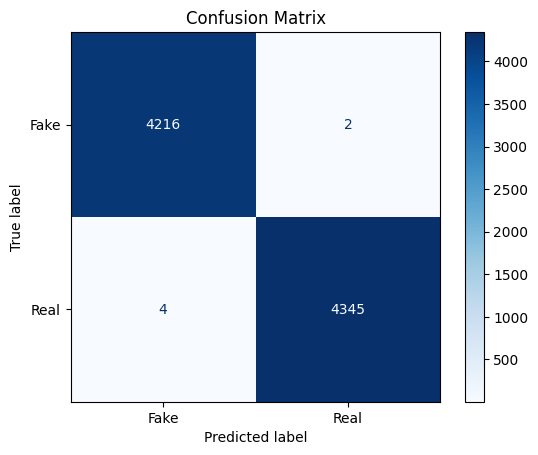

In [121]:
# STEP 13: Evaluate Model with Classification Report and Confusion Matrix
predictions = trainer.predict(dataset['test'])
preds = torch.argmax(torch.tensor(predictions.predictions), axis=1)
true_labels = predictions.label_ids

print("\nClassification Report:\n")
print(classification_report(true_labels, preds, target_names=["Fake", "Real"]))

cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [122]:
# STEP 14: Predict Custom Headline
def predict_headline(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    label = torch.argmax(probs).item()
    return "Real News ✅" if label == 1 else "Fake News ❌"

# EXAMPLE PREDICTION
print(predict_headline("The Prime Minister announces new health initiative for rural areas"))

Fake News ❌


In [123]:
print(predict_headline("NASA's Artemis II mission to send astronauts around the Moon in 2025"))


Fake News ❌
